# Predicting taxi orders for the next hour

The company "Chyotenkoe taxi" collected historical data on taxi orders at airports. In order to attract more drivers during peak load periods, it is necessary to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the _RMSE_ metric on the test sample should be no more than 48.

You need to:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and conclude.


The data is in the file `taxi.csv`. The number of orders is in the column `num_orders`.

## Preparation

In [1]:
!pip install -U pandas

In [2]:
!pip install -U scikit-learn

### Data overview

In [3]:
import matplotlib
import sklearn

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [4]:
sklearn.__version__

'1.5.1'

In [5]:
pd.__version__

'2.2.2'

In [6]:
df = pd.read_csv('/datasets/taxi.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


We have a dataset containing 26496 records. There are two features:
* `datetime` - date and time in string format
* `num_orders` - number of orders, target feature

### Changing the data type for dates

In [9]:
# Change the data type to a more suitable one
df['datetime'] = pd.to_datetime(df['datetime'])

In [10]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


### Index change

In [12]:
# replace the dataset index with the datetime attribute
df = df.set_index('datetime')

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Checking the index for monotonicity

In [15]:
# Check that the new index increases monotonically
df = df.sort_index()

display(df.index.is_monotonic_increasing)
display(df.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

### Plotting a graph

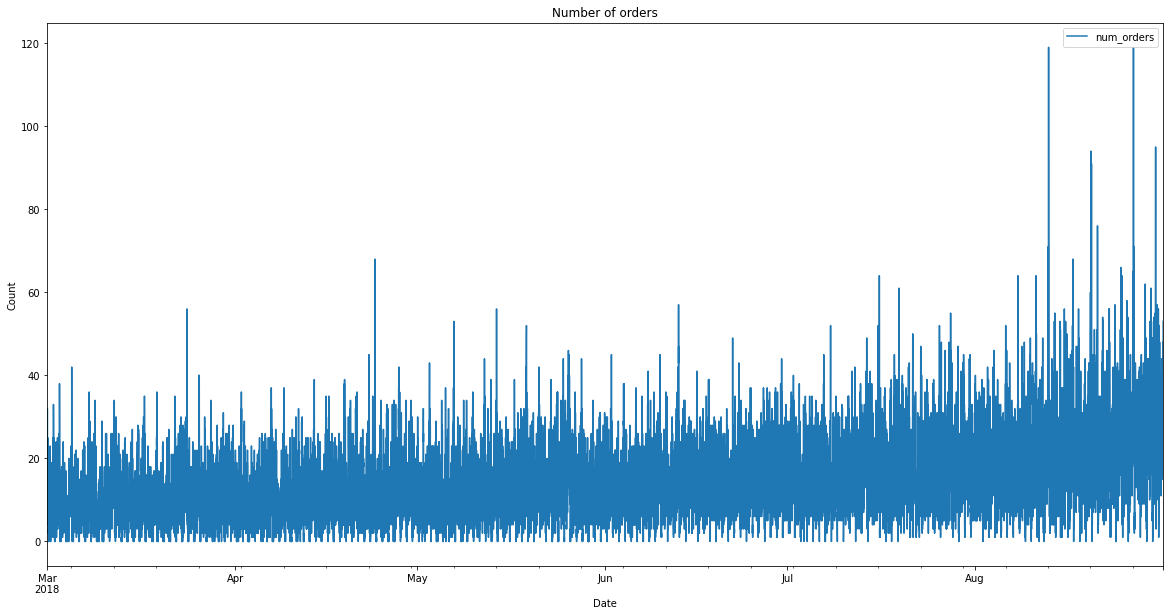

In [16]:
# Plot a graph of our time series
ax = df.plot(figsize=(20, 10), title='Number of orders')

ax.set_ylabel('Count')
ax.set_xlabel('Date')

plt.show()

### Conclusion

We have a time series of almost 26,500 records. The graph shows a trend towards an increase in the number of orders over time.

## Analysis

### Resampling

Since we need to predict data for the next hour, we resample our time series by 1 hour.

In [17]:
df = df.resample('1h').sum()

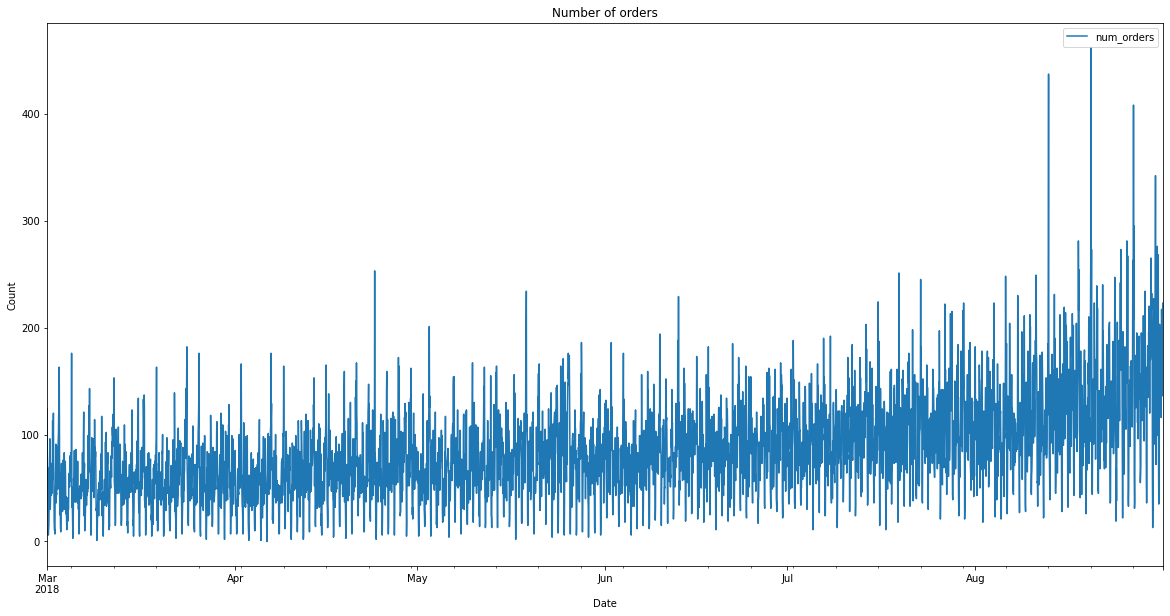

In [18]:
ax = df.plot(figsize=(20, 10), title='Number of orders')

ax.set_ylabel('Count')
ax.set_xlabel('Date')

plt.show()

### Rolling mean

For the rolling mean, we will select a window size equal to 10 records.

In [19]:
rolling_mean = df['num_orders'].rolling(10).mean()

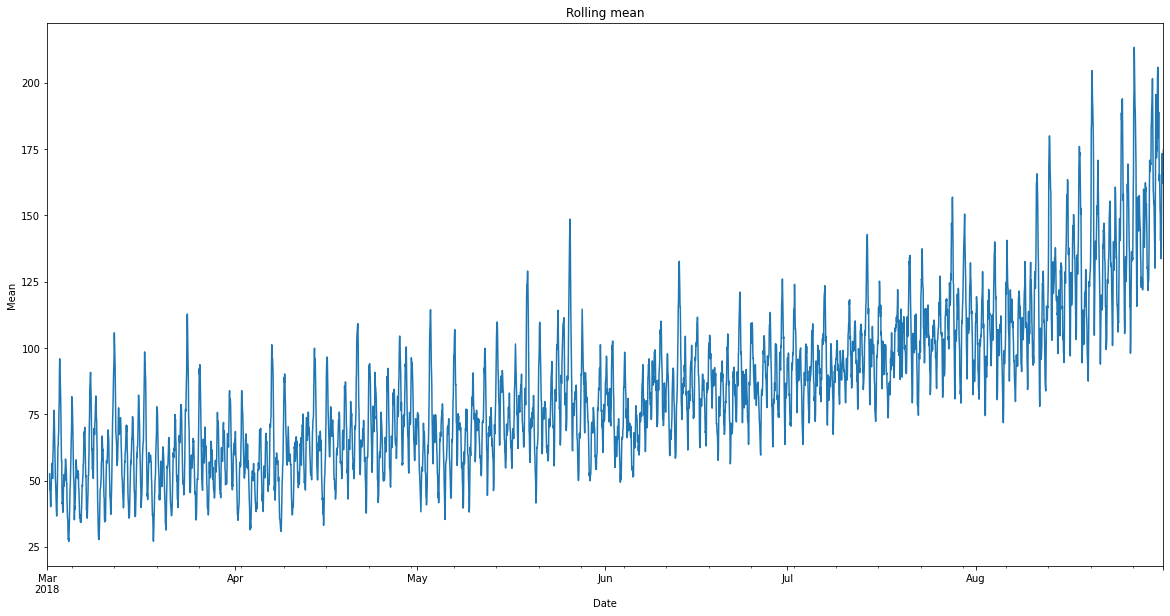

In [20]:
ax = rolling_mean.plot(figsize=(20, 10), title='Rolling mean')

ax.set_ylabel('Mean')
ax.set_xlabel('Date')

plt.show()

### Trend and seasonality

#### For all time

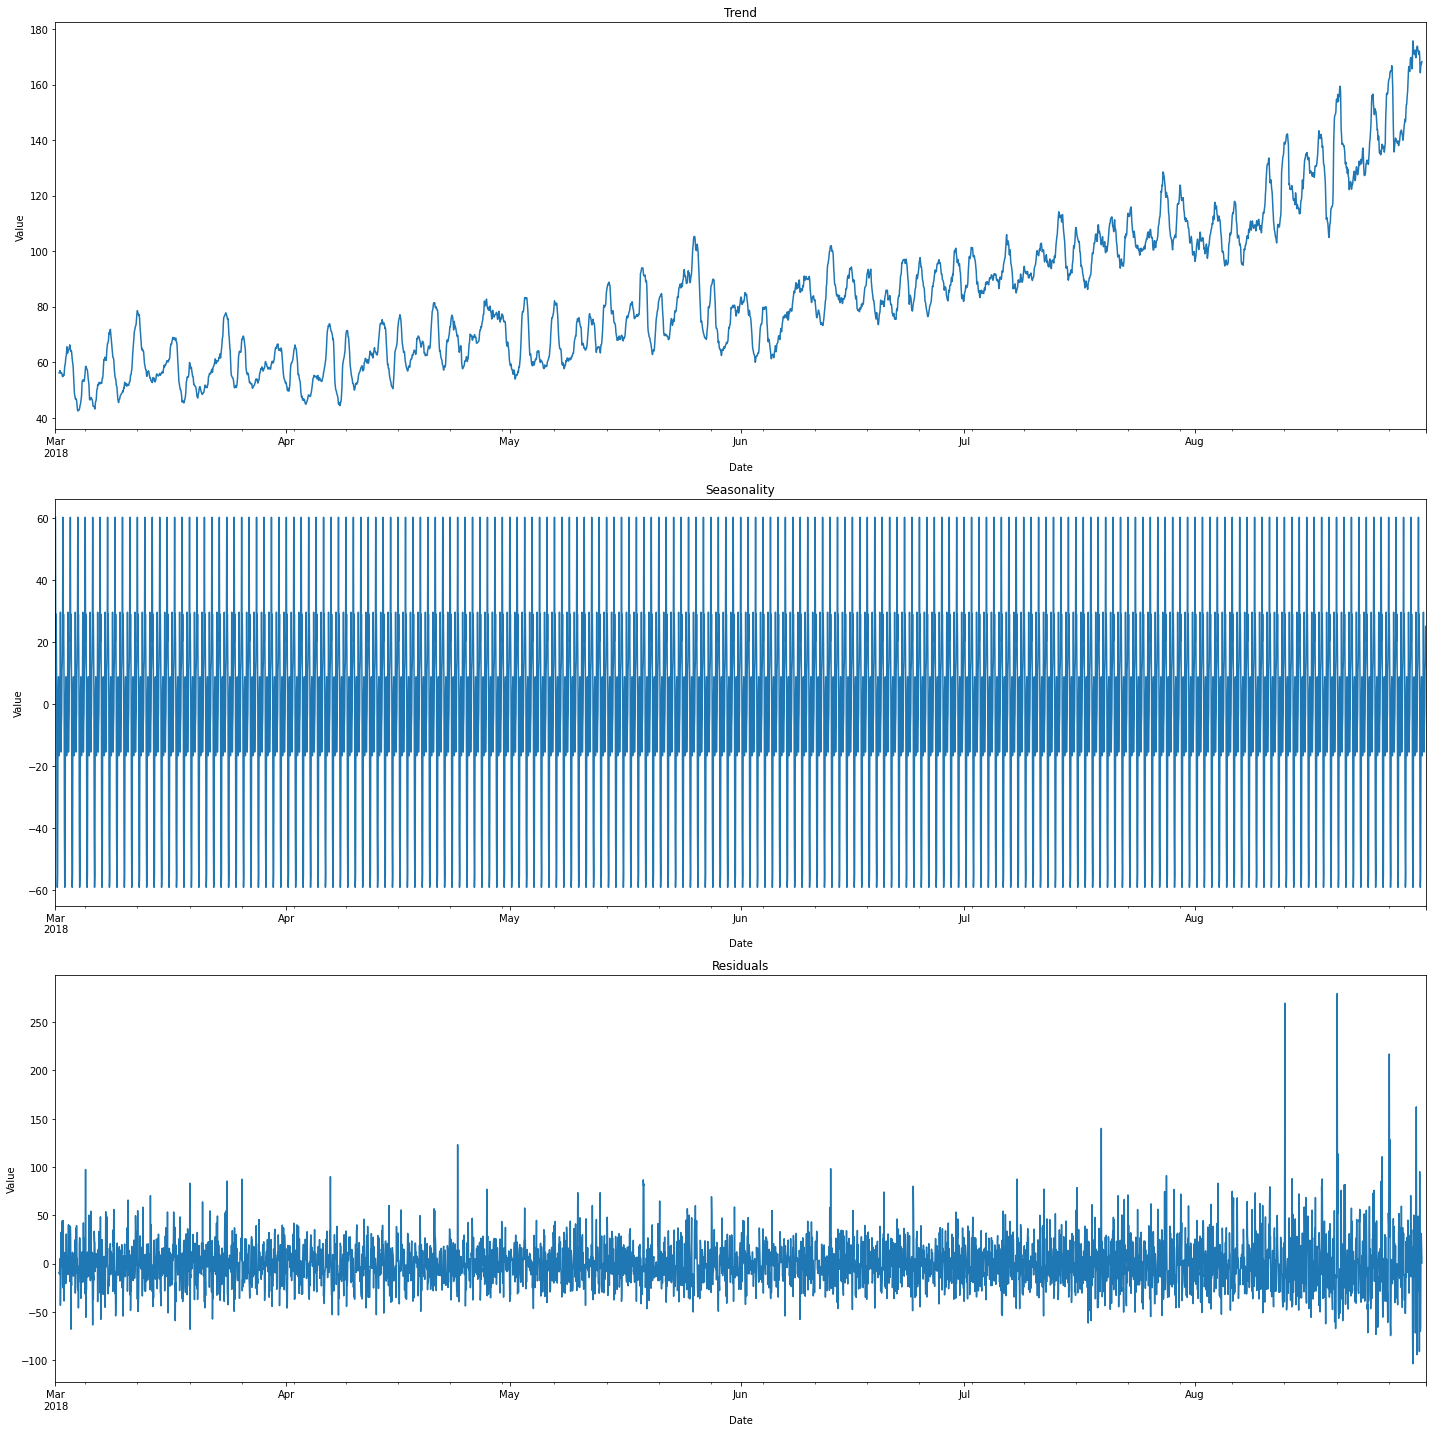

In [21]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(20, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Value')
plt.xlabel('Date')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Value')
plt.xlabel('Date')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Value')
plt.xlabel('Date')

plt.tight_layout()

#### Daily seasonality

Text(0.5, 0, 'Date')

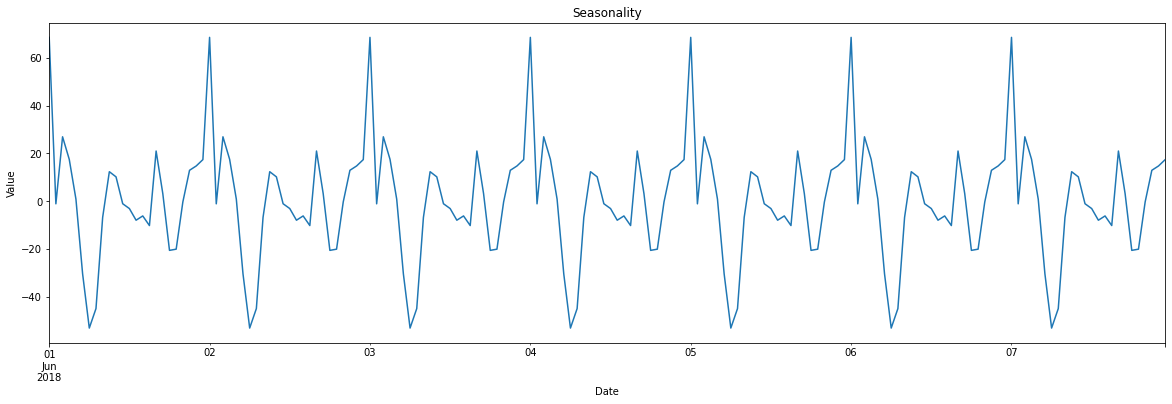

In [22]:
daily_data_slice = df['2018-06-01':'2018-06-07']

decomposed = seasonal_decompose(daily_data_slice['num_orders'])

plt.figure(figsize=(20, 20))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Value')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

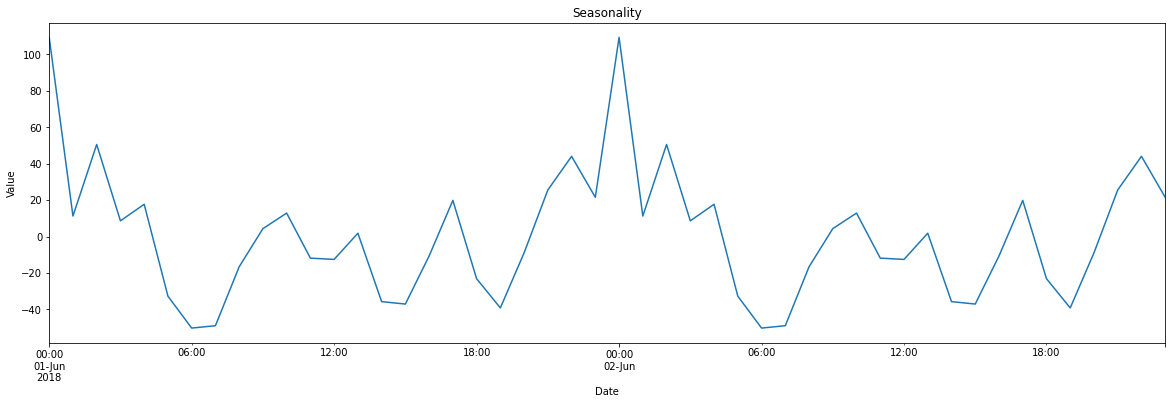

In [23]:
# Take a two-day sample to better see the seasonality
daily_data = df['2018-06-01':'2018-06-02']

decomposed = seasonal_decompose(daily_data['num_orders'])

plt.figure(figsize=(20, 20))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Value')
plt.xlabel('Date')

#### Weekly seasonality

In [24]:
# Resample by day to better see weekly seasonality
# Add a day of the week feature to compare the seasonality chart with the days of the week
weekly_data = df.resample('1D').sum()

weekly_data['dayofweek'] = weekly_data.index.dayofweek

Text(0.5, 0, 'Date')

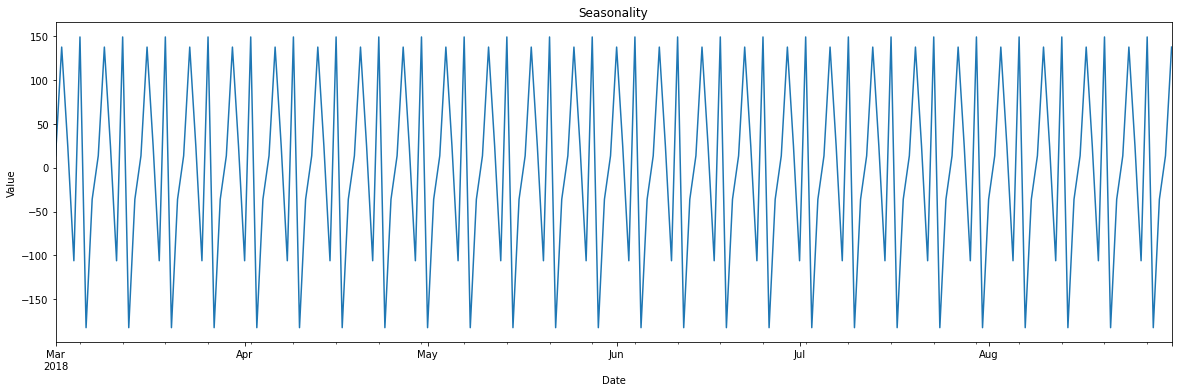

In [25]:
decomposed = seasonal_decompose(weekly_data['num_orders'])

plt.figure(figsize=(20, 20))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Value')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

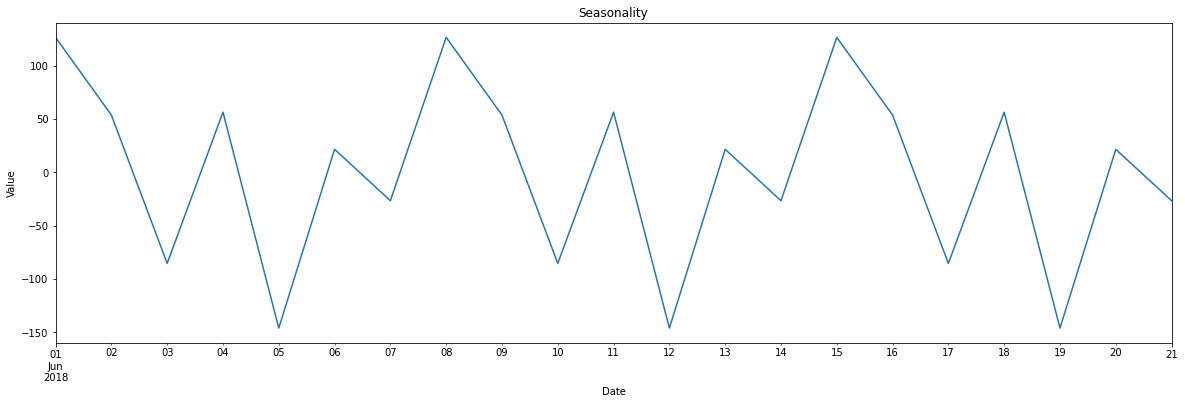

In [26]:
# Take a snapshot on day 21 to better see the seasonality
weekly_data_slice = weekly_data['2018-06-01':'2018-06-21']

decomposed = seasonal_decompose(weekly_data_slice['num_orders'])

plt.figure(figsize=(20, 20))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Value')
plt.xlabel('Date')

In [27]:
# Output the first 10 lines of our slice to match the days of the week with the date: 0 - Monday, 6 - Sunday
weekly_data_slice.head(10)

,num_orders,dayofweek
datetime,,
2018-06-01,1956,4
2018-06-02,1725,5
2018-06-03,1569,6
2018-06-04,1868,0
2018-06-05,1493,1
2018-06-06,1687,2
2018-06-07,1880,3
2018-06-08,2079,4
2018-06-09,2155,5


### Conclusion

The trend towards an increase in the number of orders over time is clearly visible. The trend accelerates in August. It can be assumed that this is due to an increase in the customer base.

Daily seasonality shows a peak in orders around midnight (0:00). The minimum number of orders is around 6 am. From 6 to 12, the number of orders increases. Then there is a decline and an increase around 5 pm. A decline around 7 pm and a subsequent increase towards midnight.

Weekly seasonality shows an increase in orders on Monday and a subsequent decline on Tuesday. Then there is an increase in orders on Wednesday and a slight decline on Thursday from the peaks on Friday. On Saturday and Sunday, the number of orders decreases.

Towards the end of the time series, the share of leftovers increases. Certainly, more difficult-to-explain data will be included in the test sample.

## Training

### Creating additional features

Let's write a function to create additional features

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    
    for i in range(1, max_lag + 1):
        data_copy[f'lag_{i}'] = data_copy['num_orders'].shift(i)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_copy

We will set the max_lag value to 24, and the moving average to 24.

In [29]:
df_w_features = make_features(df, 168, 24)

/tmp/ipykernel_103/1004387440.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[f'lag_{i}'] = data_copy['num_orders'].shift(i)
/tmp/ipykernel_103/1004387440.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[f'lag_{i}'] = data_copy['num_orders'].shift(i)
/tmp/ipykernel_103/1004387440.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

In [30]:
df_w_features.head(15)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data partitioning and scaling

In [31]:
X = df_w_features.drop('num_orders', axis=1)
y = df_w_features['num_orders']

In [32]:
X.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
y.head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: h, Name: num_orders, dtype: int64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.1, 
    random_state=987654321,
    shuffle=False)

Let's check that the samples are divided correctly - the test sample starts immediately after the training sample.

In [35]:
X_train.tail()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 09:00:00,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,136.0,134.041667
2018-08-13 10:00:00,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,135.250000
2018-08-13 11:00:00,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,137.250000
2018-08-13 12:00:00,13,0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,67.0,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,139.875000
2018-08-13 13:00:00,13,0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,104.0,138.583333


In [36]:
X_test.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,13,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,138.541667
2018-08-13 15:00:00,13,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,138.458333
2018-08-13 16:00:00,13,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,139.541667
2018-08-13 17:00:00,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,139.166667
2018-08-13 18:00:00,13,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,125.0,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,140.708333


#### Removing gaps in the training sample

Let's remove the gaps at the beginning of the training sample - they will not improve the quality of training.

In [37]:
X_train = X_train.dropna()

In [38]:
y_train = y_train[X_train.index]

In [39]:
X_train.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,8,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,8,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,8,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,8,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,8,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [40]:
y_train.head()

datetime
2018-03-08 00:00:00    143
2018-03-08 01:00:00     78
2018-03-08 02:00:00     65
2018-03-08 03:00:00     68
2018-03-08 04:00:00     60
Freq: h, Name: num_orders, dtype: int64

In [41]:
display(X_train.shape)
display(X_test.shape)

(3806, 171)

(442, 171)

#### Feature scaling

Let's scale all the features.

In [42]:
num_features = X_train.columns.values

In [43]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [44]:
scaler = StandardScaler()
scaler.fit(X_train_copy[num_features])

X_train_copy[num_features] = scaler.transform(X_train_copy[num_features])
X_test_copy[num_features] = scaler.transform(X_test_copy[num_features])

In [45]:
X_train_copy.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,-0.870514,-0.013391,0.378907,1.231736,0.740999,-0.086030,-0.758317,0.509699,-0.810219,-0.861773,...,-1.150033,-1.659063,-1.738524,-1.898052,-0.905325,-0.288139,-0.153312,0.223072,1.270605,-1.005876
2018-03-08 01:00:00,-0.870514,-0.013391,1.645921,0.378599,1.232344,0.741925,-0.085457,-0.758355,0.509667,-0.810017,...,-0.210290,-1.149080,-1.658032,-1.737132,-1.897563,-0.905114,-0.287642,-0.153108,0.222851,-0.911401
2018-03-08 02:00:00,-0.870514,-0.013391,-0.034812,1.645378,0.378955,1.233524,0.742678,-0.085510,-0.758459,0.509761,...,-0.344539,-0.209638,-1.148247,-1.656672,-1.736660,-1.897638,-0.905561,-0.287458,-0.153266,-1.005876
2018-03-08 03:00:00,-0.870514,-0.013391,-0.370958,-0.035043,1.646108,0.379695,1.234383,0.742607,-0.085576,-0.758261,...,0.514654,-0.343844,-0.209169,-1.147093,-1.656208,-1.736688,-1.899606,-0.905469,-0.287593,-0.915795
2018-03-08 04:00:00,-0.870514,-0.013391,-0.293386,-0.371127,-0.034809,1.647501,0.380369,1.234301,0.742588,-0.085433,...,-1.257432,0.515075,-0.343323,-0.208394,-1.146680,-1.656213,-1.738409,-1.899660,-0.905499,-0.911401


In [46]:
X_test_copy.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,-0.298606,-1.512443,1.025343,0.326894,1.671969,1.983858,1.493175,0.302670,-1.043140,-0.344213,...,0.648903,0.568757,-0.262830,0.730305,0.220999,1.509134,3.419875,1.082913,0.572102,3.133459
2018-08-13 15:00:00,-0.298606,-1.512443,0.585767,1.024915,0.327235,1.673375,1.984880,1.493088,0.302626,-1.042919,...,1.132199,0.649281,0.568924,-0.262034,0.730527,0.221535,1.512384,3.420605,1.082546,3.129065
2018-08-13 16:00:00,-0.298606,-1.512443,2.473359,0.585420,1.025462,0.327948,1.674330,1.984782,1.493111,0.302737,...,2.125641,1.132423,0.649417,0.569385,-0.261711,0.731210,0.222813,1.512833,3.419843,3.186190
2018-08-13 17:00:00,-0.298606,-1.512443,1.671779,2.472663,0.585838,1.026535,0.328610,1.674238,1.984834,1.493125,...,0.648903,2.125547,1.132371,0.649845,0.569623,-0.261314,0.733269,0.223072,1.512394,3.166416
2018-08-13 18:00:00,-0.298606,-1.512443,1.878638,1.671231,2.473637,0.586684,1.027349,0.328549,1.674272,1.984807,...,1.293298,0.649281,2.125110,1.132604,0.650075,0.570260,-0.260776,0.733603,0.222851,3.247709


### Training models

In [47]:
# Function to find the best model
def best_model_search_cv(model, params):
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(model, params, cv=tscv, n_jobs=1, scoring='neg_root_mean_squared_error')
    grid.fit(X_train_copy, y_train)
    return grid.best_estimator_, grid.best_score_, grid.best_params_

#### Linear regression

In [48]:
model_lr = LinearRegression().fit(X_train_copy, y_train)
predictions_lr = model_lr.predict(X_train_copy)
rmse_lr = root_mean_squared_error(y_train, predictions_lr)

display(f'RMSE of Linear Regression: {rmse_lr}')

'RMSE of Linear Regression: 20.356451931288742'

#### Random Forest

In [49]:
# Parameters for the first run of GridSearchCV

params = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt','log2', 1],
    'max_depth' : range(2, 11, 4),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 6, 2)
}

# Best parameters obtained after the first run of GridSearchCV

params = { 
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'max_depth' : [6],
    'min_samples_leaf': [3],
    'min_samples_split': [2]
}


estimator_rf = RandomForestRegressor(random_state=42)

best_model_rf, best_score_rf, best_params_rf = best_model_search_cv(estimator_rf, params)

display(f'Best params: {best_params_rf}')
display(f'RMSE-score of the best model: {-best_score_rf}')

"Best params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}"

'RMSE-score of the best model: 25.219171630328827'

#### LightGBM

In [50]:

# Parameters for the first run of GridSearchCV

params = {
    "max_depth": [3, 4, 6, 5, 10],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}


# Best parameters obtained after the first run of GridSearchCV

params = {
    "max_depth": [3],
    "num_leaves": [10],
    "learning_rate": [0.05],
    "n_estimators": [100],
    "colsample_bytree": [0.7]
}


estimator_lgb = lgb.LGBMRegressor(random_state=42, n_jobs=1)

best_model_lgb, best_score_lgb, best_params_lgb = best_model_search_cv(estimator_lgb, params)

display(f'Best params: {best_params_lgb}')
display(f'RMSE of the best model: {-best_score_lgb}')

"Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10}"

'RMSE of the best model: 22.61076312093602'

#### Conclusion

Three models were trained: linear regression, random forest, LightGBM. As a result, the following RMSE metrics were obtained:

In [51]:
display(f'RMSE')
display(f'Linear Regression: {rmse_lr.round(5)}')
display(f'Random Forest: {-best_score_rf.round(5)}')
display(f'LightGBM: {-best_score_lgb.round(5)}')

'RMSE'

'Linear Regression: 20.35645'

'Random Forest: 25.21917'

'LightGBM: 22.61076'

The linear regression model performed best. The LightGBM model came in second. The random forest came in third. We will use our linear regression model to test the test sample.

## Testing

### Estimation of the previous value of the series x(t-1)

Let's test our model using prediction through the previous value of the series.

In [52]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_previous = root_mean_squared_error(y_test, pred_previous)

In [53]:
display(f'RMSE x(t-1): {rmse_previous.round(5)}')

'RMSE x(t-1): 58.85649'

Our models are more accurate than prediction via the previous value of the series x(t-1).

### Testing on a test sample

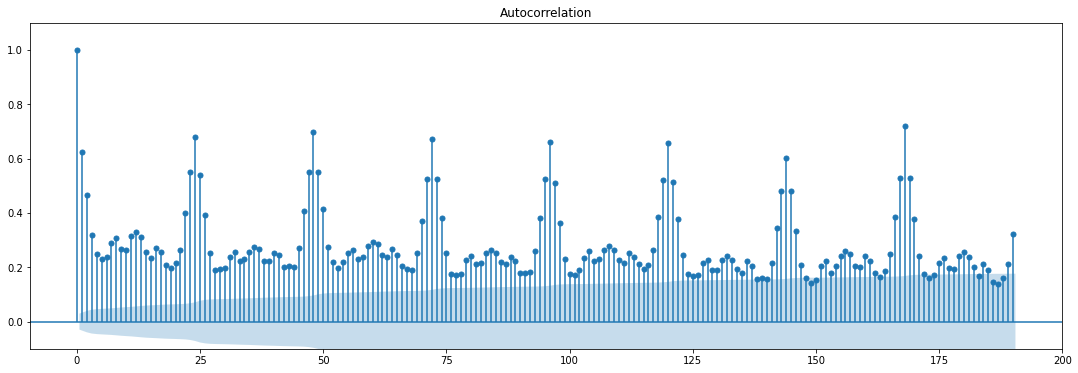

In [54]:
import matplotlib.pyplot as plt


from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1h').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



In [55]:
# Validate the model on a test sample
predictions = model_lr.predict(X_test_copy)
f'RMSE value on the test sample: {root_mean_squared_error(y_test, predictions)}'

'RMSE value on the test sample: 34.50220087343165'

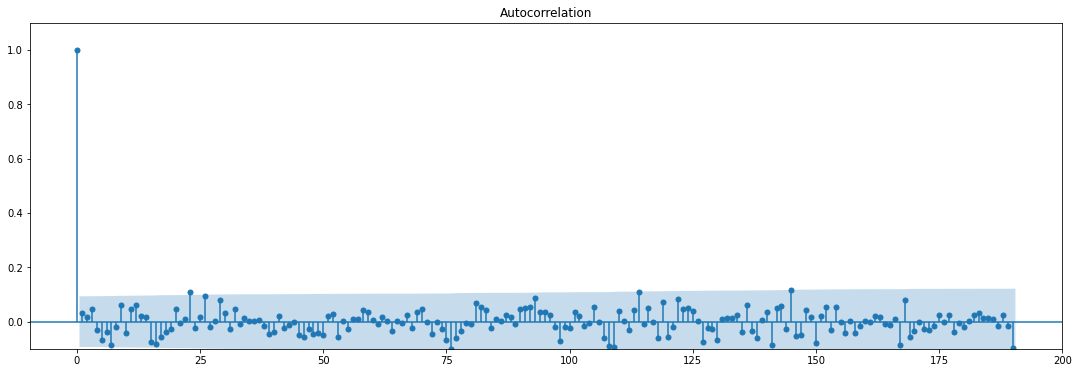

In [56]:
# Plot a graph of the autocorrelation of residuals (actual vs. forecast)
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1h').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(y_test - predictions, lags=190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

### Conclusion

To achieve the optimal result, we added additional features to our dataset: 168th lag and 24-hour moving average.

We trained several models using cross-validation and chose the best one. It turned out to be linear regression.

As a result of checking the model on the test sample, the target RMSE metric value was 34.50. This is below the required threshold of 48.